In [2]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
cal_house_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [4]:
cal_house_data = cal_house_data.reindex(np.random.permutation(cal_house_data.index))
cal_house_data["median_house_value"] /= 1000.0
cal_house_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8794,-118.6,34.2,33.0,4769.0,787.0,2019.0,743.0,5.6,338.2
7801,-118.4,34.1,28.0,833.0,230.0,349.0,210.0,3.1,375.0
6718,-118.3,34.0,44.0,1753.0,387.0,1165.0,380.0,2.1,105.8
16834,-123.3,40.4,15.0,661.0,146.0,131.0,57.0,0.5,56.7
14604,-122.2,40.2,28.0,1782.0,334.0,873.0,311.0,3.4,79.1
...,...,...,...,...,...,...,...,...,...
16551,-122.7,38.8,29.0,994.0,226.0,302.0,117.0,2.3,67.9
11790,-121.3,38.0,20.0,1591.0,589.0,1916.0,536.0,1.4,94.6
9182,-119.0,36.0,25.0,1009.0,246.0,994.0,222.0,1.8,55.8
9543,-119.3,36.3,18.0,2603.0,478.0,1158.0,423.0,4.6,150.5


In [5]:
cal_house_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [6]:
# Define the input feature: total_rooms.
my_feature = cal_house_data[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [7]:
# Define the label.
targets = cal_house_data["median_house_value"]

In [8]:
# Use gradient descent as the optimizer for training the model.
my_optimizer= tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_Optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regresion model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [9]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epoch=None):
    """Trains a linear regression model of one feature.
    
    Args:
        features: pandas DataFrame of features
        targets: "" of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely.
    Returns:
        Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}

    # Construct a dataset, and configure batching/repreating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epoch)

    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels





In [10]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

In [11]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epoch=1, shuffle=False)

# Call predict() on the linear regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 1253052454825.005
Root Mean Squared Error (on training data): 1119398.256


In [12]:
min_house_value = cal_house_data["median_house_value"].min()
max_house_value = cal_house_data["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 1119398.256


In [15]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,-863525.9,207.3
std,712057.2,116.0
min,-12391731.0,15.0
25%,-1029323.5,119.4
50%,-694762.8,180.4
75%,-477547.4,265.0
max,-653.4,500.0


In [16]:
sample = cal_house_data.sample(n=300)

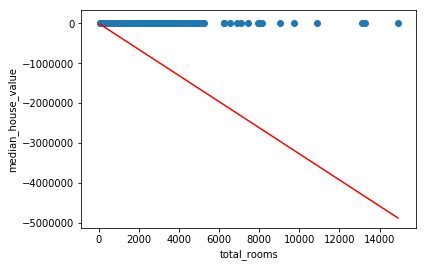

In [17]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

In [ ]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
    """Trains a linear regression model of one feature.
        
        Args:
            learning_rate: A `float`, the learning rate.
            steps: A non-zero `int`, the total number of training steps. A training step
                consists of a forward and a backward pass using a single batch.
            batch_size: A non-zero `int`, the batch size.
            input_feature: A `strings` specifying a column from `cal_house_data` to use as 
                input feature.
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = cal_house_data[[my_feature]]
    my_label = "median_house_value"
    targets = cal_house_data[my_label]
    
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epoch=1, shuffle=Faslse)
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = cal_house_data.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets)
        )
        # Occasionally print the current loss.
        print(" period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extends = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                         sample[my_feature].max()),
                            sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training fininshed.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %0.2f" %)